<h1>Código - Artigo ENCOENG 2020</h1> 
<h2>Classificadores Boosting x Diabetes</h2>
<h3>Oziel Senior</h3>

### Principais bibliotecas 

In [1]:
pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [2]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFECV
import operator
import warnings
warnings.simplefilter(action = "ignore")

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.neighbors import LocalOutlierFactor
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Leitura da Base

In [3]:
#from google.colab import files
#uploaded = files.upload()

url = 'https://raw.githubusercontent.com/ozseniorcl13/pima_indians/main/diabetes.csv'

df = pd.read_csv(url)

### 2. Análise Exploratória de Dados - EDA

#### 2.1 Estatística descritiva da base

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<p>A base de dados consiste nas variáveis médicas preditoras (independetes) :
    <ol>
        <li>Pregnancies</li>
        <li>Glucose</li>
        <li>BloodPressure</li>
        <li>SkinThickness</li>
        <li>Insulin</li>
        <li>DiabetesPedigreeFunction</li>
        <li>Age</li>
    </ol>
    E uma variável <b>Outcome</b> dependente, que indica se o paciente sofre ou não de diabetes
</p>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


<p>Aparentemente a base não demonstra possuir valores faltantes, onde todos seus registros possuem valor preenchido</p>

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


<p>É possível verificar que algumas colunas possuem 0 como valor mínimo:
    <ol>
        <li>Glucose</li>
        <li>BloodPressure</li>
        <li>SkinThickness</li>
        <li>Insulin</li>
        <li>BMI</li>
    </ol> 
</p>
<p>Essa informações parecem estranhas, o que pode caracterizar uma discrepância nesses dados. Tais questões serão investigadas mais a frente</p>     

#### 2.2 Visualização dos dados

In [7]:
def bar_plot():
    fig = plt.figure(figsize = (5, 6), dpi = 100)
    ax = fig.add_subplot(1, 1, 1)

    ax = df.Outcome.value_counts().plot.bar(ax = ax, rot = 0, fontsize = 12, color = (sns.color_palette()[7], sns.color_palette()[1])).set(xticklabels = ["Saudável", "Diabético"])

    plt.suptitle('Quantitativo - Pacientes Saudáveis x Diabéticos', fontsize = 13)
    plt.show()

In [8]:
def pie_plot():
    fig = plt.figure(figsize = (5, 6), dpi = 100)
    ax = fig.add_subplot(1, 1, 1)

    ax = fig.add_subplot(111)
    ax = df.Outcome.value_counts().plot.pie(labels = ("Saudável", "Diabético"), autopct = "%.2f%%", label = "", fontsize = 11, ax = ax,\
    colors = (sns.color_palette()[7], sns.color_palette()[1]), wedgeprops = {"linewidth": 1.5, "edgecolor": "#F7F7F7"}), ax.texts[1].set_color("#F7F7F7"), ax.texts[3].set_color("#F7F7F7")
    plt.suptitle('Percentual - Pacientes Saudáveis x Diabéticos', fontsize = 13)
    plt.show()

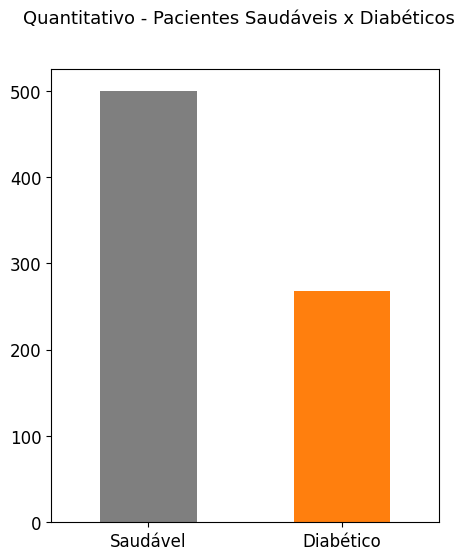

In [9]:
bar_plot() 

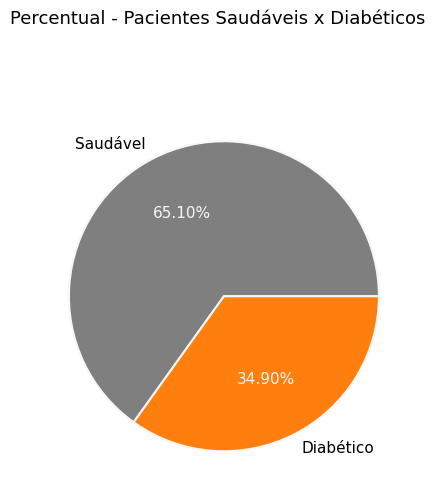

In [10]:
pie_plot()

<p>A partir de análise dos gráficos, é possível perceber: <p>
    <ul>
        <li>268 dos registros são de pacientes diabéticos</li>
        <li>500 dos registros são de pacientes saudáveis</li>
    </ul>
<p>A base apresenta um certo desbalanceamento em relação a proporção dos dois diferentes tipos de registros. De modo a conduzir os testes, é necessário tomar cuidado com essa característica</p>

#### 2.3 Distribuição dos dados (boxplot)

O boxplot permite visualizar a distribuição dos dados de modo a verifiar mediana, primeiro e terceiro quartil, além de apresentar possívei valores discrepantes (outliers)

In [11]:
def box_plot():
    f, ax = plt.subplots(figsize = (11, 15))

    ax.set_facecolor('#fafafa')
    ax.set(xlim = (-0.5, 200))
    plt.ylabel('Colunas da base')
    plt.title('Visão geral da distribuição dos dados')
    ax = sns.boxplot(data = df,
                     orient = 'h',
                     palette = 'Set1'
                    )

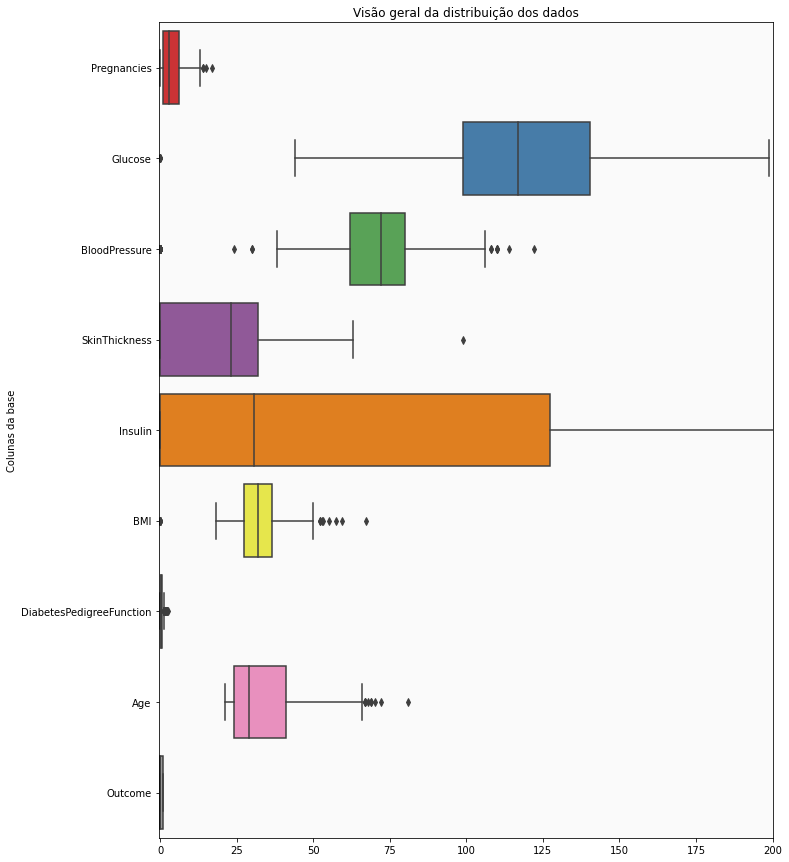

In [12]:
box_plot()

#### 2.4 Investigação de missing values

<p> Como visto anteriomente, alguns valores possuem valores discrepantes, isto é, 0 em colunas que não podem ter esse valor <p>
<p> Isto pode caracterizar missing value que precisará ser identificado e tratado </p>

In [13]:
columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in columns:
    df[col].replace(0, np.NaN, inplace = True)

In [14]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<p>É possível verificar o grande número de missing values em 5 colunas: </p>
    <ul> 
        <li>Glucose - 5</li>
        <li>BloodPressure - 35 </li>
        <li>SkinThickness - 227</li>
        <li>Insulin - 374</li>
        <li>BMI - 11</li>
    </ul>
    
<p>Como existem muitos registros que possuem valores discrepantes, torna-se necessário tratar estes valores antes de fazer a aplicação da rede neural</p>

#### 2.5 Preenchendo missing values

<p>
    Nesse trabalho, abordagem utilizada para preencher os missing values será a imputação simples.
    O raciocíneo para fazer esse preenchimento segue a seguinte ideia:
</p>
<p>
    Para uma coluna X de um registro, calcular duas medianas de X: mediana dos registros pertecentes ao grupo Saudável e mediana dos registros pertecentes ao grupo diabético.
    Depois de se obter as medianas dos dois grupos, preencher missing com mediana de acordo com o grupo do registro com missing value.
<p>
<p>
    Ex: <br>
    Pressão Sanguínea <br>
    Mediana grupo saudável:    10/60 <br>
    Mediana grupo diabético: 13/90 <br>
    
Registro do grupo diabético recebe 13/90 para preencher sua coluna Pressao Sanguínea(BloodPressure)
</p>

In [15]:
def medians_col(col):   
    temp = df[df[col].notnull()]
    temp = df[[col, 'Outcome']].groupby(['Outcome'])[[col]].median()
    return temp

In [16]:
for col in columns:
    print(medians_col(col))

         Glucose
Outcome         
0          107.0
1          140.0
         BloodPressure
Outcome               
0                 70.0
1                 74.5
         SkinThickness
Outcome               
0                 27.0
1                 32.0
         Insulin
Outcome         
0          102.5
1          169.5
          BMI
Outcome      
0        30.1
1        34.3


<p>Medianas conforme coluna e tipo de registro:</p>
<table>
    <tr>
        <td>Glicose</td>>
        <td>107 para pacientes saudáveis</td>
        <td>140 para pacientes diabéticos</td>
    </tr>
    <tr>
        <td>Pressão Sanguínea</td>>
        <td>70 para pacientes saudáveis</td>
        <td>74.5 para pacientes diabéticos</td>
    </tr>
    <tr>
        <td>Dobra da pele</td>>
        <td>27 para pacientes saudáveis</td>
        <td>32 para pacientes diabéticos</td>
    </tr>
    <tr>
        <td>Insulina</td>>
        <td>102.5 para pacientes saudáveis</td>
        <td>169.5 para pacientes diabéticos</td>
    </tr>
    <tr>
        <td>IMC</td>>
        <td>30.1 para pacientes saudáveis</td>
        <td>34.3 para pacientes diabéticos</td>
    </tr>
</table>

In [17]:
for col in columns:
    median_health = medians_col(col)[col][0]
    median_diabetic = medians_col(col)[col][1]
    df.loc[(df['Outcome'] == 0) & (df[col].isnull()), col] = median_health
    df.loc[(df['Outcome'] == 1) & (df[col].isnull()), col] = median_diabetic

In [18]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### 2.6 Proucura por outliers

<p>Como os algoritmos que serão testados podem ter seu desempenho comprometido
pela presença de Outliers nos dados, será feita uma busca por colunas que apresentem
valores discrepantes (outliers).
</p>

In [19]:
def search_cols_outliers():
    for col in df.select_dtypes(include = ['float', 'int']):
        q1 = df[col].quantile(0.05)
        q3 = df[col].quantile(0.95)
        i = q3 - q1
        
        lim_max = q3 + 1.5 * i
        lim_min = q1 - 1.5 * i
        
        if df[(df[col] > lim_max)].any(axis = None):
            print(col, 'outiler')

In [20]:
search_cols_outliers()

SkinThickness outiler
Insulin outiler


<p>A primeiro momento, é possível verificar que as colunas SkinThickness e Insulin possuem valores
discrepantes e precisam ser tratadas.</p>

<p>
A abordagem para tentar diminuir o número de outliers será de substituí-los pelo valor do limite máximo  e mínimo de forma a ter uma distribuição mais normal nos dados da coluna
</p>

In [21]:
col_outliers = ['Insulin', 'SkinThickness']
for col in col_outliers:
    q1 = df[col].quantile(0.05)
    q3 = df[col].quantile(0.95)
    i = q3 - q1

    lim_max = q3 + 1.5 * i
    lim_min = q1 - 1.5 * i
    
    df.loc[df[col] > lim_max, col] = lim_max
    df.loc[df[col] < lim_min, col] = lim_min

<p>Após amenizar os desvios na distribuição das colunas Insulin e SkinThickness, será utilizado
o algoritmo LOF (Local Outlier Factor).</p>
<p>O LOF considera a densidade de um ponto p (registro) e a densidade (resto da base) de seus k-vizinhos gerando no final um fator ou grau de anomalia para cada registro. Quanto maior o grau, maior a chance do registro ser um outlier.
</p>

In [22]:
lof = LocalOutlierFactor(n_neighbors = 20)

y_pred = lof.fit_predict(df)
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)

threshold = np.sort(df_scores)[8]

In [23]:
df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:30]

array([-2.53962794, -2.47311403, -2.3029262 , -2.01224601, -1.87179524,
       -1.79510701, -1.79016565, -1.73291587, -1.73036284, -1.71069014,
       -1.69480987, -1.67337946, -1.66442466, -1.65622435, -1.64098802,
       -1.62785005, -1.56687416, -1.56530855, -1.53974319, -1.53818437,
       -1.52934553, -1.52753616, -1.51902536, -1.50229042, -1.49579659,
       -1.48561171, -1.48431992, -1.47179041, -1.4695407 , -1.46694203])

In [24]:
threshold = np.sort(df_scores)[8]

In [25]:
threshold

-1.7303628392576187

In [26]:
df = df[df_scores > threshold]

In [27]:
df.shape

(759, 9)

## 3. Pré-processamento

#### 3.1 Separação de dados de treino e teste

In [28]:
y = df['Outcome']
X = df.drop(["Outcome"], axis = 1)
cols = X.columns
index = X.index

#### 3.2 Aplicação do MinMaxScaler

In [29]:
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)
X = pd.DataFrame(X, columns = cols, index = index)

### 4. Treinamento e validação usando K-Fold Cross Validation (K = 5)

In [30]:
models = []

models.append(('GBM', GradientBoostingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('CatBoost', CatBoostClassifier(verbose = False)))
models.append(('LGBM', LGBMClassifier()))

In [31]:
results = []
names = []

for name, model in models:
    cv_results = cross_val_score(model, X, y, cv = 5, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: Acurácia de %f com Desvio Padrão de (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

GBM: Acurácia de 0.895931 com Desvio Padrão de (0.012646)
AdaBoost: Acurácia de 0.869589 com Desvio Padrão de (0.016163)
CatBoost: Acurácia de 0.884071 com Desvio Padrão de (0.016868)
LGBM: Acurácia de 0.890685 com Desvio Padrão de (0.022498)


<p>A acurácia de classificação pelos algoritmos baseado em Boosting para pacientes diabéticos e não diabéticos aparenta ser promissora comparada a outras abordagens clássicas encontradas na literatura</p>

### 5. Refinamento de hiperparâmetros

<p>De modo a melhorar os resultados será utilizado a técnica GridSearch para encontrar os melhores hiperparâmetros de cada algoritmo</p>

#### 5.1 Gradient Boost Classifier

In [32]:
'''
gbm = GradientBoostingClassifier(random_state = 13)

'''
{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_split': 10,
 'n_estimators': 170,
 'subsample': 1.0}
'''

params = {
    "n_estimators": np.arange(10, 500, 10),
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.001, 0.005],
    "min_samples_split": [2, 5, 10]
}

gbm_grid = GridSearchCV(
                gbm,
                params,
                cv = 5,
                n_jobs = -1,
                verbose = 2
).fit(X, y)
'''

'\n\nparams = {\n    "n_estimators": np.arange(10, 500, 10),\n    "subsample": [0.6, 0.8, 1.0],\n    "max_depth": [3, 4, 5],\n    "learning_rate": [0.1, 0.001, 0.005],\n    "min_samples_split": [2, 5, 10]\n}\n\ngbm_grid = GridSearchCV(\n                gbm,\n                params,\n                cv = 5,\n                n_jobs = -1,\n                verbose = 2\n).fit(X, y)\n'

In [33]:
# gbm_grid.best_params_

In [34]:
gbm_best = {
  'learning_rate': 0.1,
  'max_depth': 4,
  'min_samples_split': 10,
  'n_estimators': 170,
  'subsample': 1.0
 }

In [35]:
gbm_tuned = GradientBoostingClassifier(**gbm_best)

In [36]:
cross_val_score(gbm_tuned, X, y, cv = 5).mean()

0.9025357267340539

In [37]:
# gbm_tuned = GradientBoostingClassifier(**gbm_grid.best_params_)

In [38]:
# cross_val_score(gbm_tuned, X, y, cv = 5).mean()

#### 5.2 AdaBoost

In [39]:
adboost = AdaBoostClassifier(random_state = 123)

# dict_keys(['algorithm', 'base_estimator', 
# 'learning_rate', 'n_estimators', 'random_state'])

adboost.get_params().keys()

params = {
    "n_estimators": np.arange(10, 500, 10),
    "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3]
}

adboost_grid = GridSearchCV(
                  adboost,
                  params,
                  cv = 5,
                  n_jobs = -1,
                  verbose = 2
).fit(X, y)

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


In [40]:
# adboost_grid.best_params_

In [41]:
ada_best = {'learning_rate': 0.3, 'n_estimators': 450}

In [42]:
adboost_tuned = AdaBoostClassifier(**ada_best)

In [43]:
cross_val_score(adboost_tuned, X, y, cv = 5).mean()

0.8827814569536423

#### 5.3 CatBoost 

In [44]:
'''
cat_boost = CatBoostClassifier(random_state = 13, verbose = 0)

params = {
    "iterations": np.arange(10, 100, 10),
    "depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],
    "l2_leaf_reg": [3, 1, 5, 10, 100],
    "loss_function": ['LogLoss', 'CrossEntropy'],
    "border_count": [32, 5, 10, 20, 50, 100, 200],
}

cb_grid = GridSearchCV(
                cat_boost,
                params,
                cv = 5,
                n_jobs = -1,
                verbose = 2
).fit(X, y)

'''



'\ncat_boost = CatBoostClassifier(random_state = 13, verbose = 0)\n\nparams = {\n    "iterations": np.arange(10, 100, 10),\n    "depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],\n    "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],\n    "l2_leaf_reg": [3, 1, 5, 10, 100],\n    "loss_function": [\'LogLoss\', \'CrossEntropy\'],\n    "border_count": [32, 5, 10, 20, 50, 100, 200],\n}\n\ncb_grid = GridSearchCV(\n                cat_boost,\n                params,\n                cv = 5,\n                n_jobs = -1,\n                verbose = 2\n).fit(X, y)\n\n'

In [45]:
# cb_grid.best_params_

In [46]:
cb_best = {
  'border_count': 200,
  'depth': 7,
  'iterations': 50,
  'l2_leaf_reg': 1,
  'learning_rate': 0.2,
  'loss_function': 'CrossEntropy'
 }

In [47]:
cb_tuned = CatBoostClassifier(**cb_best, verbose = 0)

In [48]:
cross_val_score(cb_tuned, X, y, cv = 5).mean()

0.8853781805507145

#### 5.4 LGBM

In [49]:
lgbm = LGBMClassifier(random_state = 13)

params = {
    "num_leaf": [3, 5, 8, 10, 12],
    'num_leaves': np.arange(1, 50, 10),
    "learning_rate": [0.03, 0.001, 0.01, 0.1, 0.2, 0.3],
    "n_estimators": np.arange(10, 100, 10),
    'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7]
}

lgbm_grid = GridSearchCV(
                lgbm,
                params,
                cv = 5,
                n_jobs = -1,
                verbose = 2
).fit(X, y)

Fitting 5 folds for each of 10800 candidates, totalling 54000 fits


In [50]:
lgbm_grid.best_params_

{'learning_rate': 0.03,
 'max_depth': 5,
 'n_estimators': 60,
 'num_leaf': 3,
 'num_leaves': 11}

In [51]:
lgbm_tuned = LGBMClassifier(**lgbm_grid.best_params_)

In [52]:
cross_val_score(lgbm_tuned, X, y, cv = 5).mean()

0.9077988846287905

### 6. Avaliação dos resultados

<p>
Métricas para avaliação: Acurácia, Precisão, Recall, F1, Curva ROC, Matriz de confusão 
</p>

In [53]:
def scores_table(model, title):
    scores = ['accuracy', 'precision', 'recall', 'f1']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
        
    df = pd.DataFrame(res).T
    df.loc['Média'] = df.mean()
    df.loc['Std'] = df.std()
    df = df.rename(columns={0: 'Acurácia', 1:'Precisão', 2:'Recall', 3:'F1'})

    print(df)

    cell_text = np.round(df.values, 3)
    row_labels = df.index
    col_labels = df.columns

    fig = plt.figure(dpi = 100)
    ax = fig.add_subplot(1, 1, 1)
    
    table = ax.table(cellText = cell_text, rowLabels = row_labels, colLabels = col_labels, loc = 'center right')
    table.set_fontsize(12)
    plt.suptitle(title)
    ax.axis('off')
    plt.show()

In [54]:
def show_confusion_matrix(model):
    y_pred = cross_val_predict(model, X, y, cv = 5)

    conf_matrix = confusion_matrix(y, y_pred)
    
    group_names = ['Verd Pos', 'Verd Nega', 'Falso Pos', 'Falso Nega']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    
    categories = ['Saudável', 'Diabético']
    
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
             zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    sns.heatmap(conf_matrix, xticklabels = categories, yticklabels = categories, annot = labels, fmt = '', cmap = 'binary')

In [55]:
def show_roc_curve(model, title):
    cv = KFold(n_splits=5,shuffle=False, random_state = 42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:,1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y.iloc[test], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    mean_tpr = np.mean(tprs, axis = 0)
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.figure(dpi = 100)
    plt.title(title)
    plt.plot(mean_fpr, mean_tpr, color = 'darkorange', lw = 2, label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('Taxa Verdadeiro Positivo')
    plt.xlabel('Taxa Falso Positivo')
    plt.show()

#### 6.1 GBM

       Acurácia  Precisão    Recall        F1
0      0.881579  0.875000  0.792453  0.823529
1      0.868421  0.800000  0.849057  0.814815
2      0.914474  0.916667  0.849057  0.871287
3      0.914474  0.916667  0.830189  0.860000
4      0.940397  0.901961  0.884615  0.893204
Média  0.903869  0.882059  0.841074  0.852567
Std    0.025740  0.043761  0.030019  0.029412


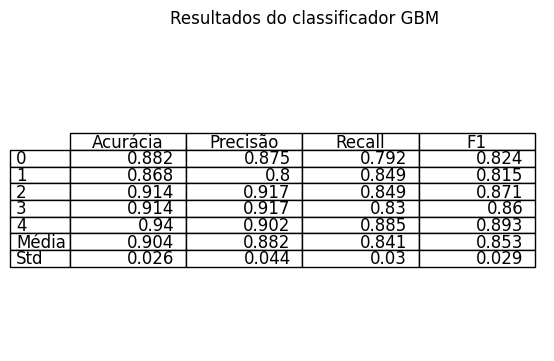

In [56]:
scores_table(gbm_tuned, 'Resultados do classificador GBM')

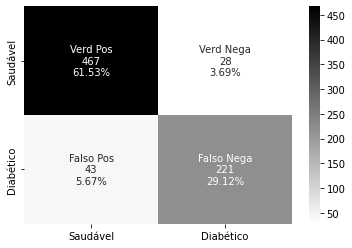

In [57]:
show_confusion_matrix(gbm_tuned)

In [58]:
# show_roc_curve(gbm_tuned, 'Curva ROC XBG')

#### 6.2 AdaBoost

       Acurácia  Precisão    Recall        F1
0      0.888158  0.875000  0.792453  0.831683
1      0.861842  0.807692  0.792453  0.800000
2      0.881579  0.843137  0.811321  0.826923
3      0.868421  0.851064  0.754717  0.800000
4      0.913907  0.882353  0.865385  0.873786
Média  0.882781  0.851849  0.803266  0.826479
Std    0.018132  0.026430  0.036096  0.027083


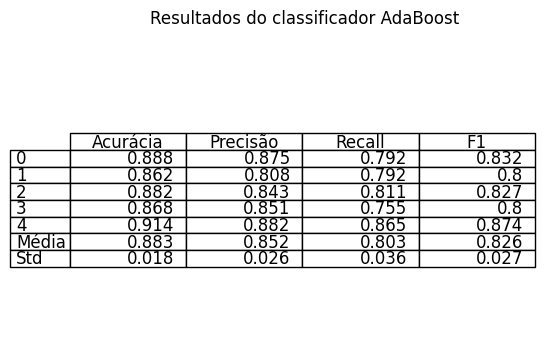

In [59]:
scores_table(adboost_tuned, 'Resultados do classificador AdaBoost')

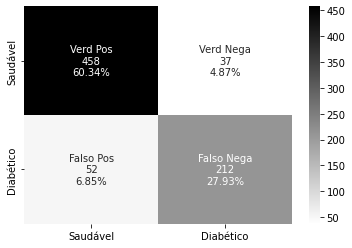

In [60]:
show_confusion_matrix(adboost_tuned)

In [61]:
# show_roc_curve(adboost_tuned, 'Curva ROC AdaBoost')

#### 6.3 CatBoost

       Acurácia  Precisão    Recall        F1
0      0.881579  0.843137  0.811321  0.826923
1      0.868421  0.800000  0.830189  0.814815
2      0.881579  0.888889  0.754717  0.816327
3      0.907895  0.882353  0.849057  0.865385
4      0.887417  0.830189  0.846154  0.838095
Média  0.885378  0.848914  0.818287  0.832309
Std    0.012865  0.033144  0.034510  0.018536


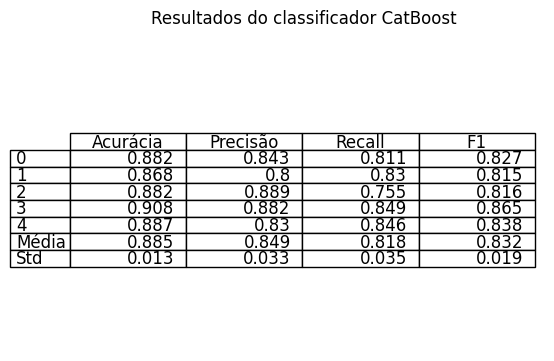

In [62]:
scores_table(cb_tuned, 'Resultados do classificador CatBoost')

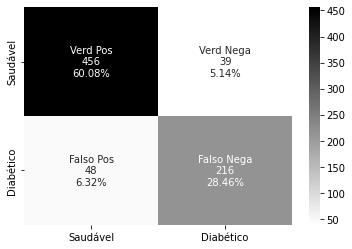

In [63]:
show_confusion_matrix(cb_tuned)

In [64]:
# show_roc_curve(cb_tuned, 'Curva ROC CatBoost')

#### 6.4 LighGBM

       Acurácia  Precisão    Recall        F1
0      0.914474  0.900000  0.849057  0.873786
1      0.861842  0.785714  0.830189  0.807339
2      0.907895  0.933333  0.792453  0.857143
3      0.927632  0.937500  0.849057  0.891089
4      0.927152  0.901961  0.884615  0.893204
Média  0.907799  0.891702  0.841074  0.864512
Std    0.024185  0.055205  0.030019  0.031428


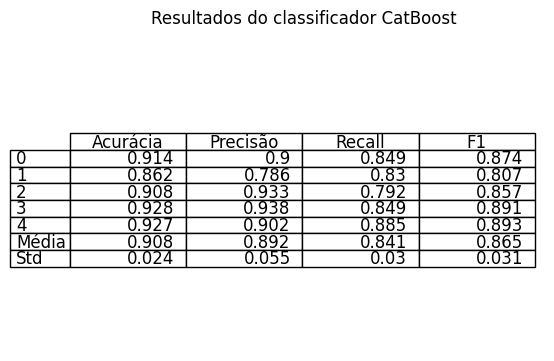

In [65]:
scores_table(lgbm_tuned, 'Resultados do classificador CatBoost')

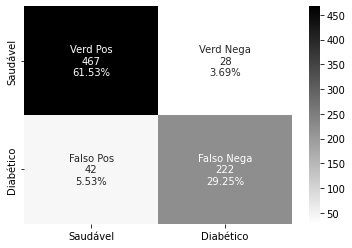

In [66]:
show_confusion_matrix(lgbm_tuned)

In [67]:
# show_roc_curve(lgbm_tuned, 'Curva ROC CatBoost')